# Experiment 06: Attention U-Net with Pretrained ResNet34 Encoder (TL-5)

In this experiment we try to improve our final model (Model 5: Attention U-Net + RAovSeg preprocessing + Focal Tversky loss) by replacing the randomly initialized encoder with a **ResNet34 encoder pretrained on ImageNet**.

### Motivation

From the previous experiments and qualitative analysis, we identified several persistent issues:

- The model struggles on **tiny or ambiguous ovaries** and often segments the “other” ovary or nearby bright structures instead of the annotated one.
- Architectural tweaks (attention), longer training, and a specialized loss (Focal Tversky) only gave **small, noisy improvements** once the model had already converged.
- We are training **from scratch** on a relatively small, noisy dataset, which makes it hard to learn robust features for small organs.

A natural next step is **transfer learning**:

> Replace the encoder of the Attention U-Net with a **ResNet34** backbone pretrained on ImageNet, and fine-tune it for ovary segmentation.

Hypothesis:
- Pretrained mid-level features (edges, textures, shapes) will help the model distinguish ovaries from surrounding tissue on challenging slices, leading to better generalization, especially on hard cases.

We keep everything else the same as Model 5:
- Dataset: **UterusDatasetWithPreprocessing** (RAovSeg preprocessing, T2FS, ovary masks).
- Loss: **FocalTverskyLoss**.
- Optimizer: **Adam**.
- Data split: 80/20 by patient.


In [1]:
# --- Imports and setup ---

import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

# Make sure we can import from src/
project_root = os.path.abspath(".")
if not os.path.exists(os.path.join(project_root, "src")):
    project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

from src.data_loader import UterusDatasetWithPreprocessing
from src.losses import FocalTverskyLoss
from src.models import DoubleConv, AttentionGate  # reuse building blocks

# --- Configuration ---

manifest_path = os.path.join(project_root, "data", "d2_manifest_t2fs_ovary_eligible.csv")
image_size = 256
batch_size = 1

warmup_epochs = 5          # encoder frozen
finetune_epochs = 25       # encoder unfrozen (total ~30 epochs; adjust if you want)
lr_decoder = 1e-4
lr_encoder = 1e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Data loading (same logic as previous experiments) ---

print("--- Loading Ovary Data with RAovSeg Preprocessing ---")
train_full_dataset = UterusDatasetWithPreprocessing(
    manifest_path=manifest_path, image_size=image_size, augment=True
)
val_full_dataset = UterusDatasetWithPreprocessing(
    manifest_path=manifest_path, image_size=image_size, augment=False
)

patient_ids = train_full_dataset.manifest["patient_id"].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids, val_ids = patient_ids[:split_idx], patient_ids[split_idx:]

train_indices = [
    i for i, sm in enumerate(train_full_dataset.slice_map)
    if train_full_dataset.manifest.loc[sm["patient_index"], "patient_id"] in train_ids
]
val_indices = [
    i for i, sm in enumerate(val_full_dataset.slice_map)
    if val_full_dataset.manifest.loc[sm["patient_index"], "patient_id"] in val_ids
]

train_dataset = Subset(train_full_dataset, train_indices)
val_dataset = Subset(val_full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(
    f"Training patients: {len(train_ids)}, Validation patients: {len(val_ids)}\n"
    f"Training slices: {len(train_dataset)}, Validation slices: {len(val_dataset)}"
)


Project root: c:\Users\lytten\programming\dlvr-project
Using device: cuda
--- Loading Ovary Data with RAovSeg Preprocessing ---
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Training patients: 44, Validation patients: 12
Training slices: 214, Validation slices: 64


In [4]:
# --- Transfer-learning Attention U-Net with ResNet34 encoder ---

import torchvision
from torchvision.models import resnet34, ResNet34_Weights

class TLAttentionUNetResNet34(nn.Module):
    """
    Attention U-Net style decoder with a ResNet34 encoder.
    - Encoder: ResNet34 pretrained on ImageNet (RGB).
    - Decoder: 4 upsampling stages with attention gates and DoubleConv blocks.
    - Input: (B, 1, H, W); we repeat the channel to 3 for ResNet.
    - Output: logits (B, 1, H, W), resized back to input resolution if needed.
    """
    def __init__(self, n_classes=1, in_channels=1, use_pretrained=True):
        super().__init__()
        self.in_channels = in_channels

        # Try to load pretrained weights; fall back to random init if download fails.
        if use_pretrained:
            try:
                encoder = resnet34(weights=ResNet34_Weights.DEFAULT)
                print("Loaded ResNet34 with ImageNet pretrained weights.")
            except Exception as e:
                print("WARNING: Could not load pretrained ResNet34 weights. "
                      "Falling back to randomly initialized encoder.\nError:", e)
                encoder = resnet34(weights=None)
        else:
            encoder = resnet34(weights=None)
            print("Using ResNet34 without pretrained weights.")

        self.encoder = encoder

        # Encoder parts
        self.conv1 = encoder.conv1
        self.bn1 = encoder.bn1
        self.relu = encoder.relu
        self.maxpool = encoder.maxpool

        self.layer1 = encoder.layer1  # output: 64 ch, /4
        self.layer2 = encoder.layer2  # 128 ch, /8
        self.layer3 = encoder.layer3  # 256 ch, /16
        self.layer4 = encoder.layer4  # 512 ch, /32

        # Decoder with attention gates (mirror the last 4 scales)
        # shapes: x1 (64, H/4), x2 (128, H/8), x3 (256, H/16), x4 (512, H/32)

        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.conv1_up = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.conv2_up = DoubleConv(256, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att3 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv3_up = DoubleConv(128, 64)

        self.up4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.att4 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.conv4_up = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Remember input spatial size (e.g. 256x256)
        input_size = x.size()[2:]

        # Repeat channel to 3 for ResNet (if input is 1-channel)
        if self.in_channels == 1 and x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)

        # Encoder
        x0 = self.conv1(x)            # -> (64, H/2, W/2)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)            # we'll use this as the highest-res skip connection

        x1 = self.maxpool(x0)         # -> (64, H/4, W/4)
        x1 = self.layer1(x1)          # -> (64, H/4, W/4)
        x2 = self.layer2(x1)          # -> (128, H/8, W/8)
        x3 = self.layer3(x2)          # -> (256, H/16, W/16)
        x4 = self.layer4(x3)          # -> (512, H/32, W/32)

        # Decoder with attention
        d4 = self.up1(x4)             # (256, H/16, W/16)
        x3_att = self.att1(g=d4, x=x3)
        d4 = self.conv1_up(torch.cat([d4, x3_att], dim=1))

        d3 = self.up2(d4)             # (128, H/8, W/8)
        x2_att = self.att2(g=d3, x=x2)
        d3 = self.conv2_up(torch.cat([d3, x2_att], dim=1))

        d2 = self.up3(d3)             # (64, H/4, W/4)
        x1_att = self.att3(g=d2, x=x1)
        d2 = self.conv3_up(torch.cat([d2, x1_att], dim=1))

        d1 = self.up4(d2)             # (64, H/2, W/2)
        x0_att = self.att4(g=d1, x=x0)
        d1 = self.conv4_up(torch.cat([d1, x0_att], dim=1))  # (64, H/2, W/2)

        out = self.outc(d1)

        # Upsample back to original input resolution (256x256)
        if out.shape[2:] != input_size:
            out = F.interpolate(out, size=input_size, mode="bilinear", align_corners=False)

        return out


def freeze_encoder(model: TLAttentionUNetResNet34):
    for p in model.encoder.parameters():
        p.requires_grad = False
    print("Encoder frozen (no gradient).")


def unfreeze_encoder(model: TLAttentionUNetResNet34):
    for p in model.encoder.parameters():
        p.requires_grad = True
    print("Encoder unfrozen (trainable).")


In [6]:
# --- Training utilities (same spirit as earlier notebooks) ---

def dice_score(preds, targets, epsilon=1e-6):
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat * targets_flat).sum()
    return (2.0 * intersection + epsilon) / (preds_flat.sum() + targets_flat.sum() + epsilon)


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(loader, desc="Training", leave=False):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    return running_loss / len(loader.dataset)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            dice = dice_score(preds, masks)
            running_loss += loss.item() * images.size(0)
            running_dice += dice.item() * images.size(0)
    return running_loss / len(loader.dataset), running_dice / len(loader.dataset)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\lytten/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 104MB/s] 


Loaded ResNet34 with ImageNet pretrained weights.

=== Phase 1: Warmup decoder (encoder frozen) ===
Encoder frozen (no gradient).

Epoch 1/30 (warmup)


  Train Loss: 0.9708 | Val Loss: 0.9378 | Val Dice: 0.1643
  -> New BEST model saved (epoch 1, Val Dice=0.1643)

Epoch 2/30 (warmup)


  Train Loss: 0.9569 | Val Loss: 0.9184 | Val Dice: 0.1666
  -> New BEST model saved (epoch 2, Val Dice=0.1666)

Epoch 3/30 (warmup)


  Train Loss: 0.9415 | Val Loss: 0.9091 | Val Dice: 0.1627

Epoch 4/30 (warmup)


  Train Loss: 0.9163 | Val Loss: 0.8877 | Val Dice: 0.1829
  -> New BEST model saved (epoch 4, Val Dice=0.1829)

Epoch 5/30 (warmup)


  Train Loss: 0.8672 | Val Loss: 0.8586 | Val Dice: 0.2574
  -> New BEST model saved (epoch 5, Val Dice=0.2574)

=== Phase 2: Fine-tune encoder + decoder ===
Encoder unfrozen (trainable).

Epoch 6/30 (finetune)


  Train Loss: 0.7905 | Val Loss: 0.8050 | Val Dice: 0.2859
  -> New BEST model saved (epoch 6, Val Dice=0.2859)

Epoch 7/30 (finetune)


  Train Loss: 0.7327 | Val Loss: 0.7839 | Val Dice: 0.2625

Epoch 8/30 (finetune)


  Train Loss: 0.6469 | Val Loss: 0.7301 | Val Dice: 0.2821

Epoch 9/30 (finetune)


  Train Loss: 0.6074 | Val Loss: 0.7428 | Val Dice: 0.2475

Epoch 10/30 (finetune)


  Train Loss: 0.5341 | Val Loss: 0.7694 | Val Dice: 0.2022

Epoch 11/30 (finetune)


  Train Loss: 0.5079 | Val Loss: 0.7284 | Val Dice: 0.2426

Epoch 12/30 (finetune)


  Train Loss: 0.4756 | Val Loss: 0.7027 | Val Dice: 0.2646

Epoch 13/30 (finetune)


  Train Loss: 0.4527 | Val Loss: 0.7468 | Val Dice: 0.2098

Epoch 14/30 (finetune)


  Train Loss: 0.4272 | Val Loss: 0.6821 | Val Dice: 0.2902
  -> New BEST model saved (epoch 14, Val Dice=0.2902)

Epoch 15/30 (finetune)


  Train Loss: 0.4078 | Val Loss: 0.8593 | Val Dice: 0.1064

Epoch 16/30 (finetune)


  Train Loss: 0.4087 | Val Loss: 0.8217 | Val Dice: 0.1407

Epoch 17/30 (finetune)


  Train Loss: 0.4047 | Val Loss: 0.7713 | Val Dice: 0.1851

Epoch 18/30 (finetune)


  Train Loss: 0.3691 | Val Loss: 0.7274 | Val Dice: 0.2404

Epoch 19/30 (finetune)


  Train Loss: 0.3550 | Val Loss: 0.6723 | Val Dice: 0.2717

Epoch 20/30 (finetune)


  Train Loss: 0.3369 | Val Loss: 0.7560 | Val Dice: 0.2057

Epoch 21/30 (finetune)


  Train Loss: 0.3378 | Val Loss: 0.6824 | Val Dice: 0.2768

Epoch 22/30 (finetune)


  Train Loss: 0.3119 | Val Loss: 0.7687 | Val Dice: 0.1891

Epoch 23/30 (finetune)


  Train Loss: 0.3066 | Val Loss: 0.7342 | Val Dice: 0.2308

Epoch 24/30 (finetune)


  Train Loss: 0.3484 | Val Loss: 0.8108 | Val Dice: 0.1503

Epoch 25/30 (finetune)


  Train Loss: 0.3276 | Val Loss: 0.7461 | Val Dice: 0.2152

Epoch 26/30 (finetune)


  Train Loss: 0.2999 | Val Loss: 0.7477 | Val Dice: 0.2047

Epoch 27/30 (finetune)


  Train Loss: 0.3098 | Val Loss: 0.8133 | Val Dice: 0.1522

Epoch 28/30 (finetune)


  Train Loss: 0.2938 | Val Loss: 0.8346 | Val Dice: 0.1323

Epoch 29/30 (finetune)


  Train Loss: 0.3158 | Val Loss: 0.7038 | Val Dice: 0.2584

Epoch 30/30 (finetune)


  Train Loss: 0.2820 | Val Loss: 0.8012 | Val Dice: 0.1602

=== Finished TL training ===
Best epoch: 14 with validation Dice = 0.2902
Model saved to: c:\Users\lytten\programming\dlvr-project\models\20_tl_attn_unet_resnet34_ft_best.pth


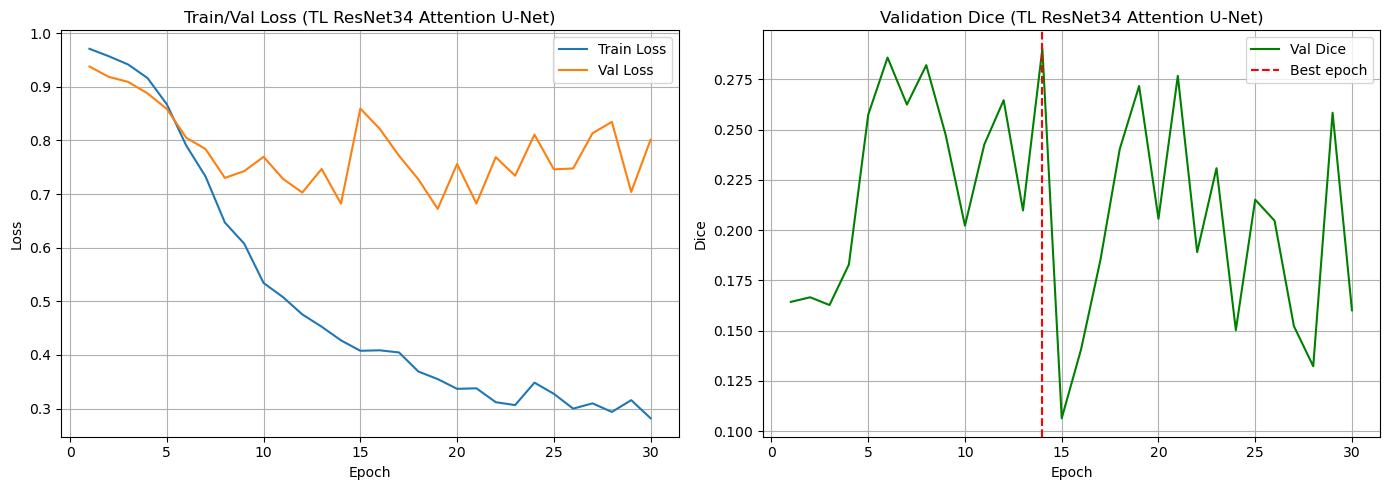

In [7]:
# --- Train TL Attention U-Net (ResNet34 encoder) ---

model = TLAttentionUNetResNet34(n_classes=1, in_channels=1, use_pretrained=True).to(device)
criterion = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

train_loss_history = []
val_loss_history = []
val_dice_history = []

best_val_dice = -1.0
best_epoch = -1
model_save_path = os.path.join(project_root, "models", "20_tl_attn_unet_resnet34_ft_best.pth")
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

print("\n=== Phase 1: Warmup decoder (encoder frozen) ===")
freeze_encoder(model)
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_decoder)

current_epoch = 0
for epoch in range(warmup_epochs):
    current_epoch += 1
    print(f"\nEpoch {current_epoch}/{warmup_epochs + finetune_epochs} (warmup)")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_dice_history.append(val_dice)

    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_epoch = current_epoch
        torch.save(model.state_dict(), model_save_path)
        print(f"  -> New BEST model saved (epoch {best_epoch}, Val Dice={best_val_dice:.4f})")

print("\n=== Phase 2: Fine-tune encoder + decoder ===")
unfreeze_encoder(model)
# Two parameter groups: smaller LR for encoder
encoder_params = list(model.encoder.parameters())
decoder_params = [p for name, p in model.named_parameters() if not name.startswith("encoder.")]
optimizer = Adam(
    [
        {"params": encoder_params, "lr": lr_encoder},
        {"params": decoder_params, "lr": lr_decoder},
    ]
)

for epoch in range(finetune_epochs):
    current_epoch += 1
    print(f"\nEpoch {current_epoch}/{warmup_epochs + finetune_epochs} (finetune)")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_dice_history.append(val_dice)

    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        best_epoch = current_epoch
        torch.save(model.state_dict(), model_save_path)
        print(f"  -> New BEST model saved (epoch {best_epoch}, Val Dice={best_val_dice:.4f})")

print("\n=== Finished TL training ===")
print(f"Best epoch: {best_epoch} with validation Dice = {best_val_dice:.4f}")
print(f"Model saved to: {model_save_path}")

# Plot training curves
epochs = list(range(1, warmup_epochs + finetune_epochs + 1))
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label="Train Loss")
plt.plot(epochs, val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train/Val Loss (TL ResNet34 Attention U-Net)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, val_dice_history, label="Val Dice", color="green")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.title("Validation Dice (TL ResNet34 Attention U-Net)")
plt.axvline(x=best_epoch, color="red", linestyle="--", label="Best epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
# --- Optional: Compare TL model vs original Model 5 on validation set ---

from src.models import AttentionUNet

model5_path = os.path.join(project_root, "models", "15_attn_unet_focal_tversky_best.pth")

# Load original Model 5
model5 = AttentionUNet(n_channels=1, n_classes=1).to(device)
model5.load_state_dict(torch.load(model5_path, map_location=device))
model5.eval()

# Reuse same criterion and dataloaders
print("\nEvaluating original Model 5...")
val_loss5, val_dice5 = validate(model5, val_loader, criterion, device)
print(f"Model 5 -> Val Loss: {val_loss5:.4f}, Val Dice: {val_dice5:.4f}")

# Load best TL model
tl_model = TLAttentionUNetResNet34(n_classes=1, in_channels=1, use_pretrained=False).to(device)
tl_model.load_state_dict(torch.load(model_save_path, map_location=device))
tl_model.eval()

print("\nEvaluating TL ResNet34 Attention U-Net...")
val_loss_tl, val_dice_tl = validate(tl_model, val_loader, criterion, device)
print(f"TL-5 -> Val Loss: {val_loss_tl:.4f}, Val Dice: {val_dice_tl:.4f}")



Evaluating original Model 5...


Model 5 -> Val Loss: 0.6575, Val Dice: 0.3090
Using ResNet34 without pretrained weights.

Evaluating TL ResNet34 Attention U-Net...


TL-5 -> Val Loss: 0.6821, Val Dice: 0.2902


## Qualitative Comparison: Model 5 vs TL-5 (Top 10 / Bottom 10 by Model 5 Loss)

We now compare our original best model

- **Model 5** – Attention U-Net + RAovSeg preprocessing + Focal Tversky loss

to the new transfer learning model

- **TL-5** – Attention U-Net + RAovSeg preprocessing + Focal Tversky loss  
  with a **ResNet34 encoder pretrained on ImageNet**,

on the same set of slices.

To focus on interesting cases, we:

1. Recompute the **Focal Tversky loss** for Model 5 on every validation slice.
2. Select the **10 easiest** (lowest loss) and **10 hardest** (highest loss) slices.
3. For each of these 20 slices, we plot:

   - Input MRI (plain, non-preprocessed)
   - Ground truth ovary mask
   - Model 5 prediction (raw)
   - Model 5 prediction after RAovSeg post-processing
   - TL-5 prediction (raw)
   - TL-5 prediction after RAovSeg post-processing

This allows us to see whether transfer learning changes the failure modes on easy and hard slices, even though the overall validation Dice did not improve.


In [9]:
# --- Datasets for qualitative comparison (plain + preprocessed) ---

from src.data_loader import UterusDataset  # plain
from src.RAovSeg_tools import postprocess_

# Plain MRI (for visualization)
val_full_plain = UterusDataset(
    manifest_path=manifest_path, image_size=image_size, augment=False
)
# Preprocessed MRI (what Model 5 and TL-5 expect)
val_full_prep = UterusDatasetWithPreprocessing(
    manifest_path=manifest_path, image_size=image_size, augment=False
)

# Build validation slice indices by patient (same split as earlier)
patient_ids = val_full_plain.manifest["patient_id"].unique()
split_idx = int(len(patient_ids) * 0.8)
train_ids, val_ids = patient_ids[:split_idx], patient_ids[split_idx:]

val_indices = [
    i
    for i, sm in enumerate(val_full_plain.slice_map)
    if val_full_plain.manifest.loc[sm["patient_index"], "patient_id"] in val_ids
]

print(f"Validation slices for qualitative comparison: {len(val_indices)}")

# --- Load Model 5 and TL-5 ---

from src.models import AttentionUNet

models_dir = os.path.join(project_root, "models")

model5_path = os.path.join(models_dir, "15_attn_unet_focal_tversky_best.pth")
tl5_path   = os.path.join(models_dir, "20_tl_attn_unet_resnet34_ft_best.pth")

# Original Model 5
model5 = AttentionUNet(n_channels=1, n_classes=1).to(device)
model5.load_state_dict(torch.load(model5_path, map_location=device))
model5.eval()
print("Loaded Model 5 from:", model5_path)

# TL-5 model (ResNet34 encoder) - use_pretrained=False here because we load trained weights
tl5 = TLAttentionUNetResNet34(n_classes=1, in_channels=1, use_pretrained=False).to(device)
tl5.load_state_dict(torch.load(tl5_path, map_location=device))
tl5.eval()
print("Loaded TL-5 from:", tl5_path)


Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the uterus.
Loading manifest from c:\Users\lytten\programming\dlvr-project\data\d2_manifest_t2fs_ovary_eligible.csv and creating slice map...
Slice map created. Found 278 slices containing the ovary.
Validation slices for qualitative comparison: 64
Loaded Model 5 from: c:\Users\lytten\programming\dlvr-project\models\15_attn_unet_focal_tversky_best.pth
Using ResNet34 without pretrained weights.
Loaded TL-5 from: c:\Users\lytten\programming\dlvr-project\models\20_tl_attn_unet_resnet34_ft_best.pth


In [10]:
# --- Rank validation slices by Model 5 Focal Tversky loss (using preprocessed input) ---

criterion_ft = FocalTverskyLoss(alpha=0.7, beta=0.3, gamma=4/3)

slice_losses = []

print("Computing Focal Tversky loss for Model 5 on all validation slices...")

with torch.no_grad():
    for idx in val_indices:
        img_prep, mask = val_full_prep[idx]

        img_batch = img_prep.unsqueeze(0).to(device)
        mask_batch = mask.unsqueeze(0).to(device)

        logits = model5(img_batch)
        loss = criterion_ft(logits, mask_batch)

        slice_losses.append((idx, float(loss.item())))

slice_losses_sorted = sorted(slice_losses, key=lambda x: x[1])
print(f"Computed losses for {len(slice_losses_sorted)} slices.")

k = 10  # number of easiest/hardest
k = min(k, len(slice_losses_sorted) // 2)

easiest = slice_losses_sorted[:k]
hardest = slice_losses_sorted[-k:]

print("Easiest losses:", [round(l, 4) for _, l in easiest])
print("Hardest losses:", [round(l, 4) for _, l in hardest])

ranked_indices = [idx for idx, _ in easiest] + [idx for idx, _ in hardest]
print(f"Using {len(ranked_indices)} slices (top {k} + bottom {k}) for the grid.")


Computing Focal Tversky loss for Model 5 on all validation slices...
Computed losses for 64 slices.
Easiest losses: [0.0305, 0.0778, 0.0802, 0.0807, 0.0901, 0.0917, 0.0976, 0.101, 0.1162, 0.1735]
Hardest losses: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Using 20 slices (top 10 + bottom 10) for the grid.


Generating Model 5 vs TL-5 qualitative grid...


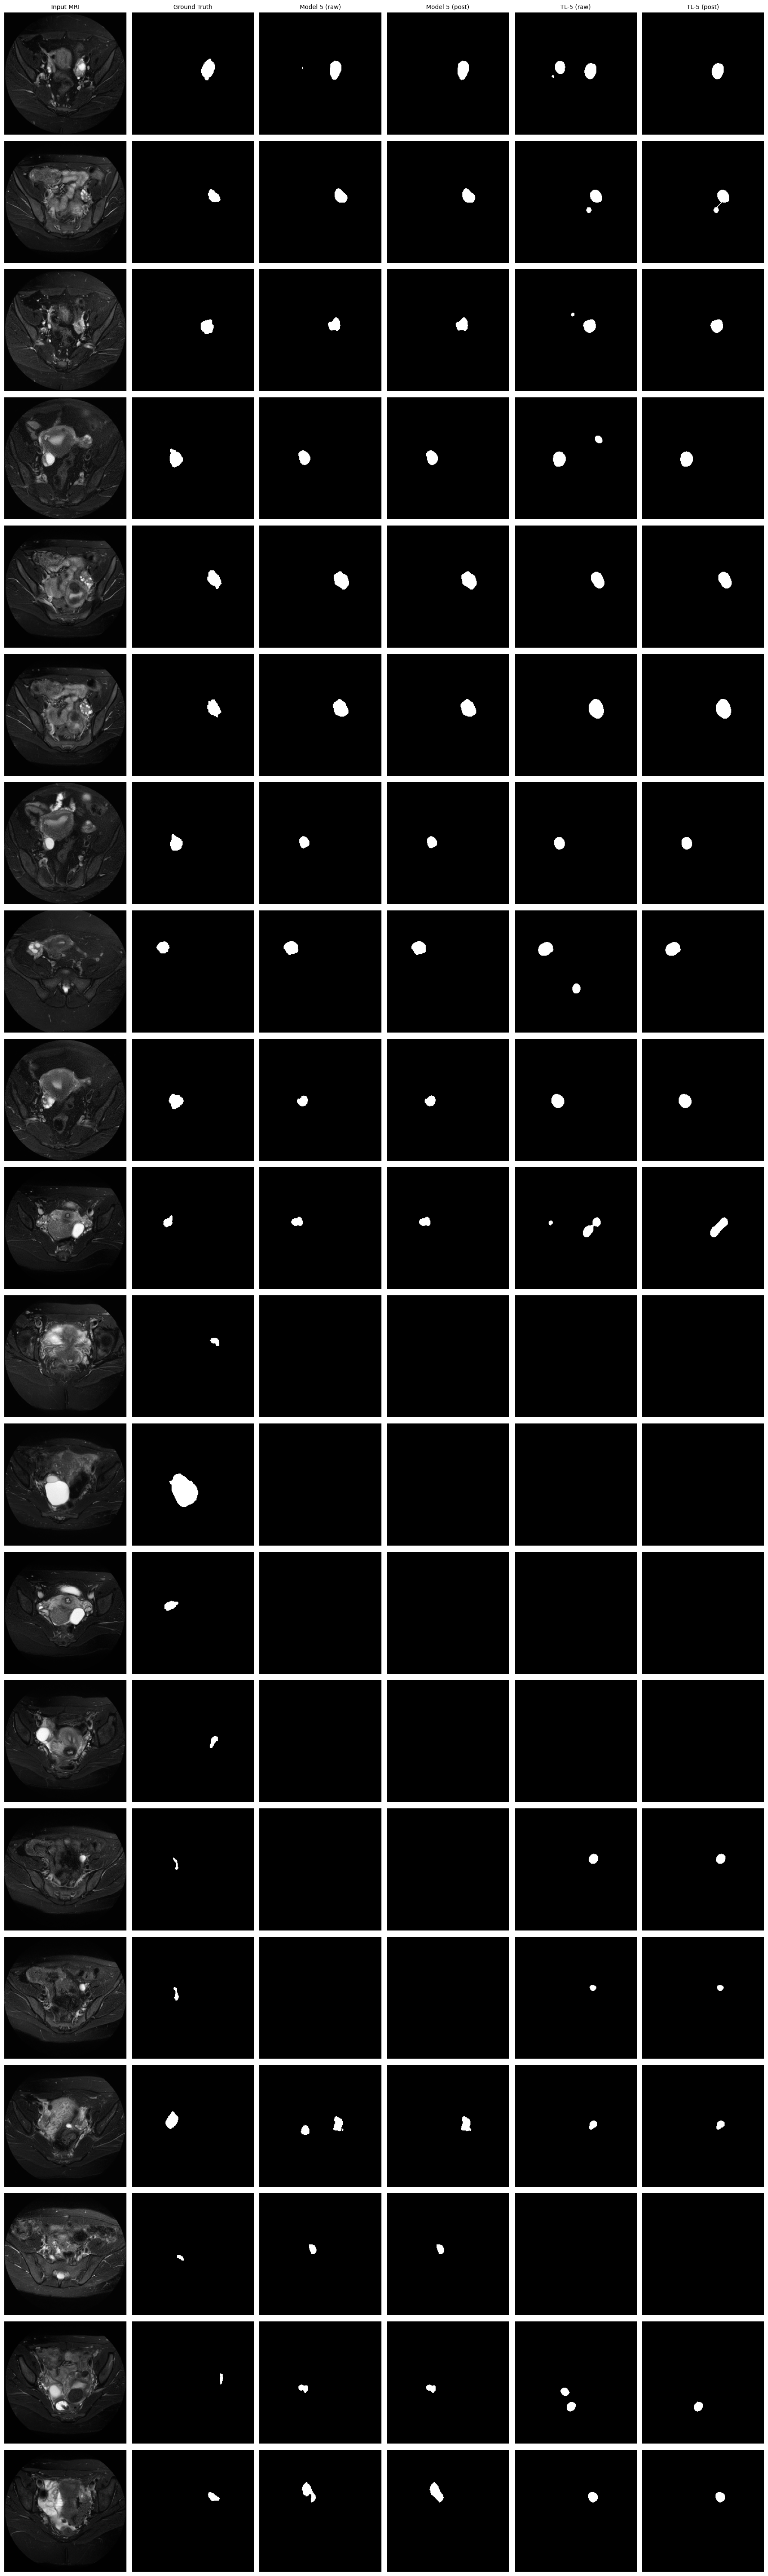

In [11]:
# --- Helper: binary prediction function for any model ---

def predict_binary_mask(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        img_batch = image_tensor.unsqueeze(0).to(device)
        logits = model(img_batch)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()
    return preds.squeeze().cpu().numpy().astype(np.uint8)


# --- Qualitative grid: Model 5 vs TL-5, raw + post-processed ---

num_rows = len(ranked_indices)
num_cols = 6  # MRI, GT, M5 raw, M5 post, TL-5 raw, TL-5 post

fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
if num_rows == 1:
    axes = np.expand_dims(axes, axis=0)

col_titles = [
    "Input MRI",
    "Ground Truth",
    "Model 5 (raw)",
    "Model 5 (post)",
    "TL-5 (raw)",
    "TL-5 (post)",
]

for col_idx, title in enumerate(col_titles):
    axes[0, col_idx].set_title(title, fontsize=10)

print("Generating Model 5 vs TL-5 qualitative grid...")

for row_idx, dataset_idx in enumerate(ranked_indices):
    img_plain, mask_tensor = val_full_plain[dataset_idx]
    img_prep, _ = val_full_prep[dataset_idx]

    mri_np = img_plain.squeeze().numpy()
    gt_np = mask_tensor.squeeze().numpy().astype(np.uint8)

    # Model 5 predictions (preprocessed input)
    pred5_raw_np = predict_binary_mask(model5, img_prep, device)
    pred5_post_np = postprocess_(pred5_raw_np)

    # TL-5 predictions (preprocessed input)
    pred6_raw_np = predict_binary_mask(tl5, img_prep, device)
    pred6_post_np = postprocess_(pred6_raw_np)

    row_axes = axes[row_idx]

    # Column 0: Input MRI
    row_axes[0].imshow(mri_np, cmap="gray")
    row_axes[0].axis("off")

    # Column 1: Ground truth
    row_axes[1].imshow(gt_np, cmap="gray")
    row_axes[1].axis("off")

    # Column 2–3: Model 5
    row_axes[2].imshow(pred5_raw_np, cmap="gray");  row_axes[2].axis("off")
    row_axes[3].imshow(pred5_post_np, cmap="gray"); row_axes[3].axis("off")

    # Column 4–5: TL-5
    row_axes[4].imshow(pred6_raw_np, cmap="gray");  row_axes[4].axis("off")
    row_axes[5].imshow(pred6_post_np, cmap="gray"); row_axes[5].axis("off")

    # Label rows as Easy vs Hard
    label = "Easy" if row_idx < k else "Hard"
    row_axes[0].set_ylabel(label, rotation=90, fontsize=9, labelpad=10)

plt.tight_layout()
plt.show()
